In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, Galactocentric
import astropy.units as u
import scipy.constants as constants
import pandas as pd
from matplotlib.ticker import NullFormatter


def load_run(filepath):
    run = {"meta": {}, "data": {}}

    with h5py.File(filepath, "r") as f:

        run["meta"]["attrs"] = dict(f.attrs)
        run["meta"]["T_obs_yr"] = f.attrs["T_obs"] / (365 * 24 * 3600)
        run["meta"]["snr_threshold"] = f.attrs.get("snr_threshold", None)
        run["meta"]["n_total_sources"] = f.attrs.get("n_total_sources", None)
        run["meta"]["iterations"] = f.attrs.get("iterations", None)

        run["data"]["global_fr"] = f["global_fr"][:]
        resolved_sources = []
        table_rows = []

        grp = f["resolved_sources"]

        for key in grp.keys():  
            g = grp[key]
            src = {"id": g.attrs["id"],
                "f0": g.attrs["f0"],
                "fdot": g.attrs["fdot"],
                "Ampl": g.attrs["Ampl"],
                "ecliptic_lat": g.attrs.get("ecliptic_lat", np.nan),
                "ecliptic_lon": g.attrs.get("ecliptic_lon", np.nan),
                "A": g["A"][:],
                "fr": g["fr"][:],
            }

            snr = g.attrs["snr"]

            resolved_sources.append({"source": src, "snr": snr})

            table_rows.append({
                "id": src["id"],
                "f0": src["f0"],
                "fdot": src["fdot"],
                "Ampl": src["Ampl"],
                "snr": snr,
                "ecliptic_lat": src["ecliptic_lat"],
                "ecliptic_lon": src["ecliptic_lon"],
            })

        run["data"]["resolved_sources"] = resolved_sources
        run["data"]["resolved_table"] = pd.DataFrame(table_rows)

        run["data"]["unresolved_indices"] = f["unresolved_indices"][:]

        psd_iter = {}
        grp_psd = f["psd_confusion"]
        for key in grp_psd.keys():
            psd_iter[key] = grp_psd[key]["psd_total"][:]

        run["data"]["psd_iter"] = psd_iter

        hist_grp = f["history"]
        run["data"]["history"] = {name: hist_grp[name][:] for name in hist_grp.keys()}

    return run


# Upload original catalog to compare resolved vs unresolved
keys = ["GW22FrequencySourceFrame", "GW22FrequencyDerivativeSourceFrame", "Amplitude","Declination", "RightAscension", "PolarisationAngle",
                "InclinationAngle", "LuminosityDistance"]
filepath_catalog = "/home/alice/catalog_binaries/catalogue_interaction_WDWD_processed.hdf5"
with h5py.File(filepath_catalog, "r") as f:
    binaries = f["Binaries"]
    params_all = {name: binaries[name][:] for name in keys}

In [2]:
runs = {}

#runs["8 yrs, pre-excl 0.001"] = load_run("/home/alice/Master-thesis-/results/results_all_snr7_8yrs_sel0001")
runs["4 yrs"] = load_run("/home/alice/Master-thesis-/euler_results/results_all_snr7_4yrs_sel000")
#runs["4 yrs, pre-excl 0.001"] = load_run("/home/alice/Master-thesis-/euler_results/results_all_snr7_4yrs_sel0001") # euler
#runs["2 yrs"] = load_run("/home/alice/Master-thesis-/euler_results/results_all_snr7_2yrs_sel000")
#runs["2 yrs, pre-excl 0.001"] = load_run("/home/alice/Master-thesis-/euler_results/results_all_snr7_2yrs_sel0001") #euler
#runs["1 yrs"] = load_run("/home/alice/Master-thesis-/euler_results/results_all_snr7_1yrs_sel000")
#runs["1 yrs, pre-excl 0.001"] = load_run("/home/alice/Master-thesis-/results/results_all_snr7_1yrs_sel0001")

In [3]:
ids = runs["4 yrs"]["data"]["resolved_table"]["id"]
dist_res = params_all["LuminosityDistance"][ids.values]
ecl_l_res = runs["4 yrs"]["data"]["resolved_table"]["ecliptic_lon"].to_numpy()
ecl_b_res = runs["4 yrs"]["data"]["resolved_table"]["ecliptic_lat"].to_numpy()

dist_all = params_all["LuminosityDistance"]
dec_all = params_all["Declination"]
ra_all = params_all["RightAscension"]

In [4]:
coords_res = SkyCoord(lon=ecl_l_res * u.rad, lat=ecl_b_res * u.rad,  distance=dist_res * u.Mpc,  frame='barycentrictrueecliptic')
galcen_res = coords_res.transform_to('galactocentric')

coords_all = SkyCoord(ra= ra_all * u.rad, dec = dec_all * u.rad, distance= dist_all * u.Mpc, frame = 'icrs')
galcen_all = coords_all.transform_to('galactocentric')

X_res = galcen_res.x.to(u.kpc).value
Y_res = galcen_res.y.to(u.kpc).value
Z_res = galcen_res.z.to(u.kpc).value

X_all = galcen_all.x.to(u.kpc).value
Y_all = galcen_all.y.to(u.kpc).value
Z_all = galcen_all.z.to(u.kpc).value

sun = Galactocentric().galcen_distance
sun = SkyCoord(x=sun, y=0 * u.kpc, z = Galactocentric().z_sun, frame = 'galactocentric')
X_sun = -sun.x.to(u.kpc).value
Y_sun = sun.y.to(u.kpc).value
Z_sun = sun.z.to(u.kpc).value

/tmp/ipykernel_5241/3794131620.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(X_res, Y_res, Z_res, '.', markersize=0.5, marker='o', color ='red', alpha=1)
/tmp/ipykernel_5241/3794131620.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc = 'upper right')


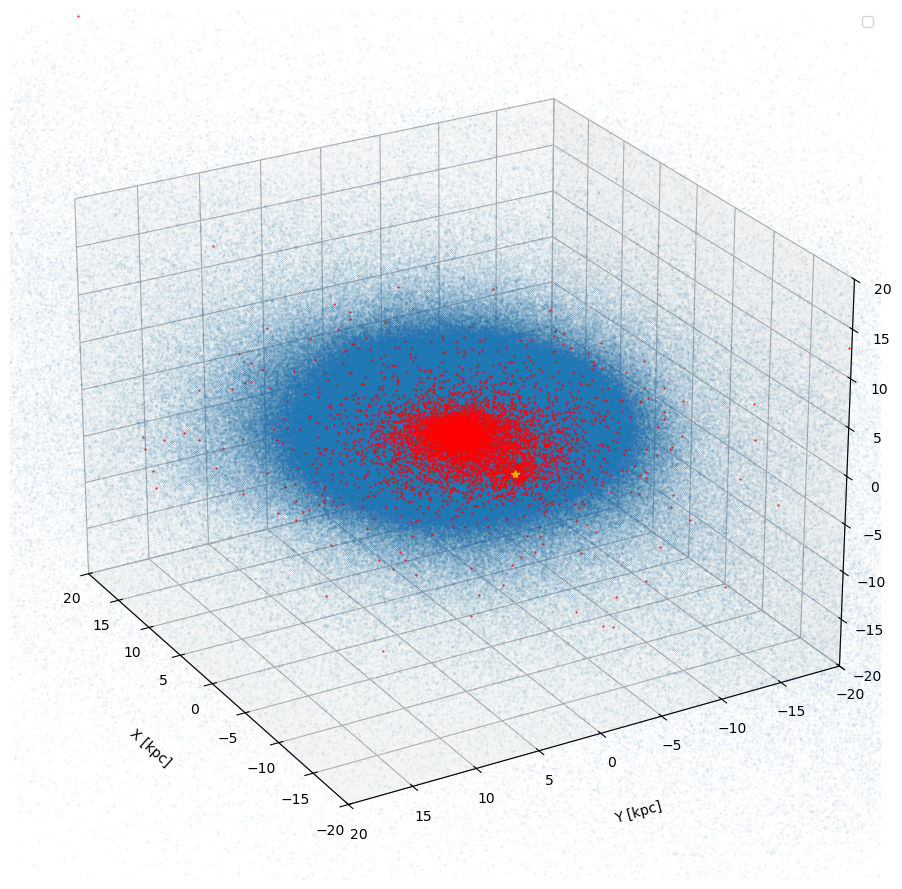

In [ ]:
from matplotlib import rcParams
from matplotlib.patches import Circle
import mpl_toolkits.mplot3d.art3d as art3d
from scipy import stats

rcParams['axes.labelpad'] = 20
markersize = 5
alpha = 0.5
fig = plt.figure(figsize=[9,9])
ax = plt.axes(projection='3d')
ax.plot(X_all, Y_all, Z_all, '.', markersize=0.1, alpha=0.3)
ax.plot(X_res, Y_res, Z_res, '.', markersize=0.5, marker='o', color ='red', alpha=1)
ax.plot(X_sun, Y_sun, Z_sun, marker='*', markersize=6, alpha=1, color = 'orange')
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')
ax.set_zlim(-20,20)
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.view_init(elev=25, azim=150) 
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

In [6]:
""" eq_coords = coords_res.transform_to('icrs')
ra_res = eq_coords.ra.wrap_at(180*u.degree).radian  
dec_res = eq_coords.dec.radian

ra_all =coords_all.ra.wrap_at(180*u.degree).radian
dec_all = coords_all.dec.radian

# Galactic center
gc = SkyCoord(l=0*u.degree, b=0*u.degree, frame='galactic')
gc_eq = gc.transform_to('icrs')
ra_gc = gc_eq.ra.wrap_at(180*u.degree).radian
dec_gc = gc_eq.dec.radian

# Equator
ra = np.linspace(0, 360, 1000) * u.deg   
dec = np.zeros_like(ra.value) * u.deg
equator = SkyCoord(ra= ra, dec=dec, frame='icrs')
ra_eq= equator.ra.wrap_at(180*u.deg).radian
dec_eq = equator.dec.radian

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='aitoff')
ax.grid(True)
ax.scatter(ra_all, dec_all, s=0.05, color='blue', alpha=0.05)
ax.scatter(ra_res, dec_res, s=0.2, color='red')
ax.set_title("Sky plot")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.show() """


' eq_coords = coords_res.transform_to(\'icrs\')\nra_res = eq_coords.ra.wrap_at(180*u.degree).radian  \ndec_res = eq_coords.dec.radian\n\nra_all =coords_all.ra.wrap_at(180*u.degree).radian\ndec_all = coords_all.dec.radian\n\n# Galactic center\ngc = SkyCoord(l=0*u.degree, b=0*u.degree, frame=\'galactic\')\ngc_eq = gc.transform_to(\'icrs\')\nra_gc = gc_eq.ra.wrap_at(180*u.degree).radian\ndec_gc = gc_eq.dec.radian\n\n# Equator\nra = np.linspace(0, 360, 1000) * u.deg   \ndec = np.zeros_like(ra.value) * u.deg\nequator = SkyCoord(ra= ra, dec=dec, frame=\'icrs\')\nra_eq= equator.ra.wrap_at(180*u.deg).radian\ndec_eq = equator.dec.radian\n\nfig = plt.figure(figsize=(10, 5))\nax = fig.add_subplot(111, projection=\'aitoff\')\nax.grid(True)\nax.scatter(ra_all, dec_all, s=0.05, color=\'blue\', alpha=0.05)\nax.scatter(ra_res, dec_res, s=0.2, color=\'red\')\nax.set_title("Sky plot")\nax.xaxis.set_major_formatter(NullFormatter())\nax.yaxis.set_major_formatter(NullFormatter())\nplt.show() '